# Telco Churn:
<hr style="border:2px solid black">

## Goal: 
* Discover drivers of churn at the TelcoCo telecommunications firm
* Use drivers to develop a machine learning model to predict customer churn
<hr style="border:2px solid black">

# Imports

In [422]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Custom Modules
import os
import env
import acquire
import prepare
import explore
import model

<hr style="border:2px solid black">

# **Acquire**
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

* Data acquired from 'telco_churn'
* It contained 7,043 rows and 24 columns before cleaning
* Each row represents a single customer
* Each column represents a feature of the customer account

In [423]:
# acquiring data using acquire.get_telco_data()
df = acquire.get_telco_data()

<hr style="border:2px solid black">

# **Prepare**

**Prepare Actions:**
* Removed columns with duplicate information
* Checked for nulls in the data (internet_service_type) and imputed for "No Internet Service"
* Changed dtype for 'total_charges' to float
* Reorganized 'payment_type' into values='Auto' and 'Manual'
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn'

In [424]:
# Clean data and split into train, validate, test with prepare.prep_telco()
train, validate, test = prepare.prep_telco(df)

<hr style="border:2px solid black">

# **Explore**
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

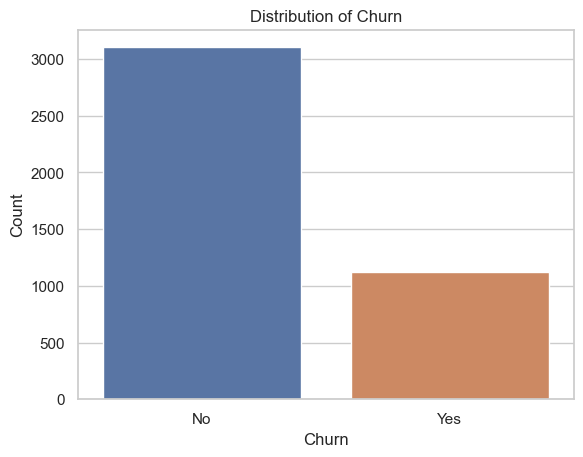

In [425]:
#### Show distribution of Target Variable 'churn'

# set target = 'churn'
target = 'churn'
# create countplot of churn for train data
sns.countplot(data=train, x=target)
plt.ylabel('Count')
plt.xlabel('Churn')
plt.title(f'Distribution of Churn')
plt.show()

> ### <u>Are monthly charges higher for customers who churn?</u>

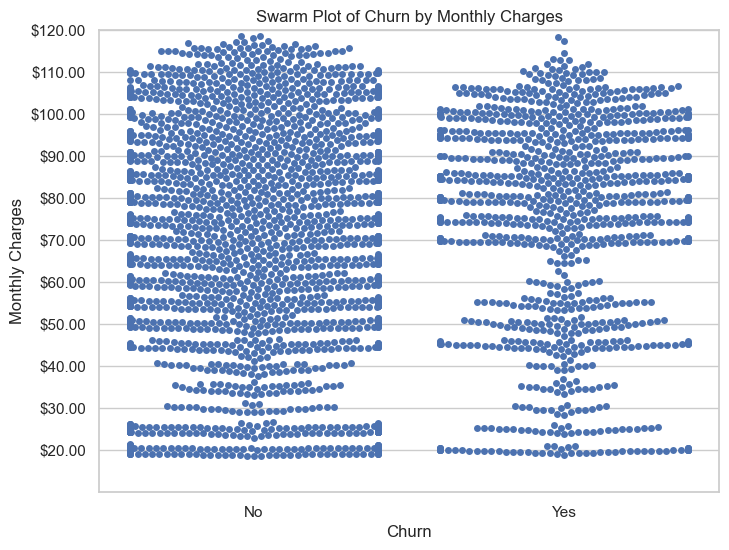

In [426]:
# Create a Swarm Plot of Churn and Monthly Charges
explore.get_swarmplot(train)

>* It looks like there is a higher concentration of churned customers when monthly charges exceed ~$70. 

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean of monthly charges of churned customers is significantly larger than the mean monthly charges for all customers.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of monthly charges of churned customers <= Mean of monthly charges of all customers.**<br>
**Ha: Mean of monthly charges of churned customers > Mean of monthly charges of all customers.**
</div>

In [427]:
#### 1 sample 1 tail T-Test

alpha = 0.05
# an array of all observed values of the subgroup
churn_sample = train[train.churn == 'Yes'].monthly_charges

# the population mean
overall_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churn_sample, overall_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

12.86165366693209 1.0358740694591168e-35 0.05
We reject the null hypothesis.


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**The alpha is less than p/2. Therefore, we have evidence to support that "Monthly Charges" and "Churn" are related. We will use monthly charges as a feature of our models.**
</div>

>### <u>Is customer churn independent of contract type?</u>

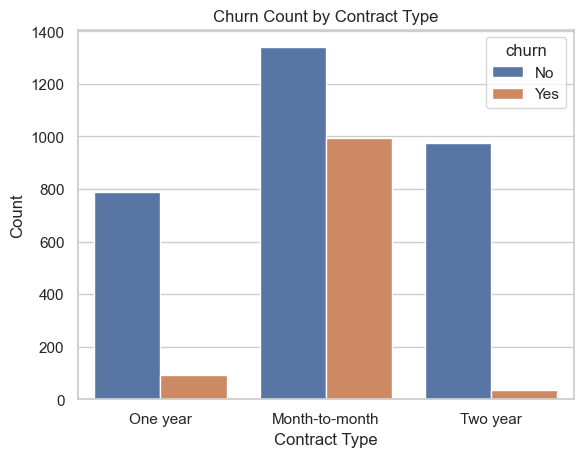

In [428]:
# Create countplot of Churn by Contract Type
explore.get_countplot_contract_type(train)

>* Churn was significant for Month-to-Month with churn count being higher than the total of one year contracts.

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a chi-square test to investigate whether "Contract Type" and "Churn" are related.**
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Customer churn rate is independent of the contract type.** <br>
**Ha: Customer churn rate has a dependent relationship to contract type.**
</div>

In [429]:
#### Chi-square Test

# Crosstab of contract_type and churn
observed = pd.crosstab(train['contract_type'], train['churn'])
# Get test statistics for chi-square
chi2, p, degf, expected = stats.chi2_contingency(observed)
# Assess for statistical significance
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between Contract Type and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between Contract Type and churn.')

p-value: 1.6908454939135029e-152
We reject the null hypothesis.
There exists some relationship between Contract Type and the churn.


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**The p-value is less than the alpha. Therefore, we have evidence to support that "Contract Type" and "Churn" are related. I believe that using the "Contract Type" feature in modeling will likely have a positive impact on the model's accuracy.**
</div>

>### <u>Is whether or not a customer churns independent of if they have automatic or manual payments?</u>

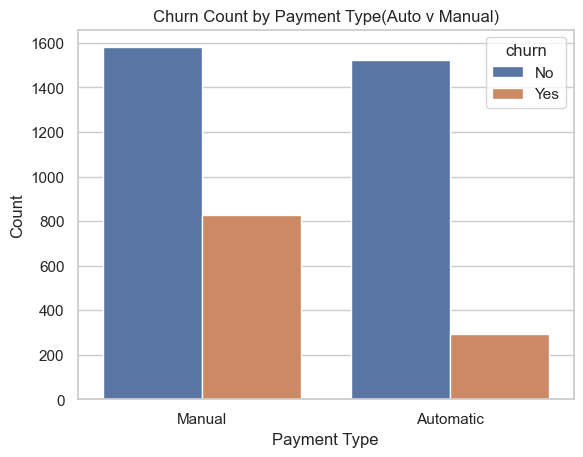

In [430]:
# Countplot of Churn for Auto and Manual payments
explore.get_countplot_pmnt(train)

>* It looks like customers with manual payments churn more often than those with automatic.

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now do a chi-square test to test for independence between payment type and Churn.**

* I will use a confidence interval of 95%
* The resulting alpha is .05

**H0: Customer churn rate is independent of the payment type.** <br>
**Ha: Customer churn rate has a dependent relationship to payment type.**
</div>

In [431]:
#### Chi-square Test

# Crosstab of payment type and churn
observed = pd.crosstab(train['mapped_payment_type'], train['churn'])
# Get test statistics for chi-square
chi2, p, degf, expected = stats.chi2_contingency(observed)
# Assess for statistical significance
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between payment type and churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between payment type and churn.')

p-value: 4.1493459283183755e-40
We reject the null hypothesis.
There exists some relationship between payment type and churn.


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**The p-value is less than the alpha. Therefore, we have evidence to support that "Payment Type" and "Churn" are related. I believe that using the "Payment Type" feature in modeling will likely have a positive impact on the model's accuracy.**
</div>

>### <u>Is customer churn independent of internet service type?</u>

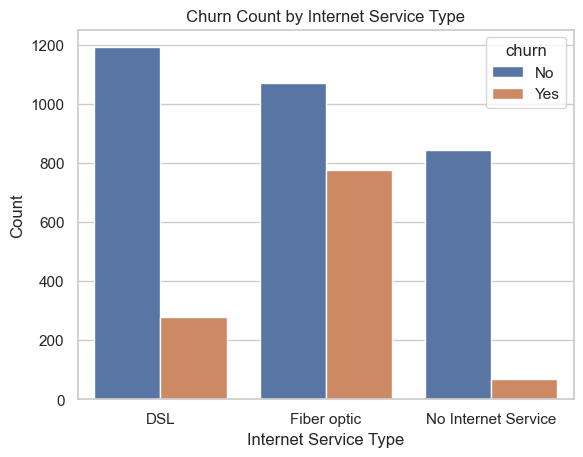

In [432]:
# Create countplot of Churn by Internet Service Type
explore.get_countplot_IST(train)

>* Fiber Optic has the highest rate of churn with ~42% of customers churning, while customers that have only phone service have the lowest rate of churn ~7.5%.

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a chi-square test to investigate weather "Internet Service Type" and "Churn" are related.**
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Customer churn rate is independent of the internet service type.** <br>
**Ha: Customer churn rate has a dependent relationship to internet service type.**
</div>

In [433]:
#### Chi-square Test

# Crosstab of internet_service_type and churn
observed = pd.crosstab(train['internet_service_type'], train['churn'])
# Get test statistics for chi-square
chi2, p, degf, expected = stats.chi2_contingency(observed)
# Assess for statistical significance
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between Internet Service Type and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between Internet Service Type and churn.')

p-value: 1.1586538084825805e-96
We reject the null hypothesis.
There exists some relationship between Internet Service Type and the churn.


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**The p-value is less than the alpha. Therefore, we have evidence to support that "Internet Service Type" and "Churn" are related. I believe that using the "Internet Service Type" feature in modeling will likely have a positive impact on the model's accuracy.**
</div>

>### <u>For fiber optic customers does the addition of tech support change churn rate?</u>


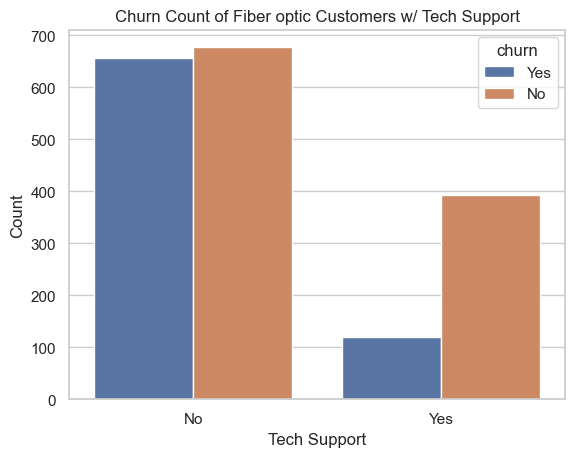

In [434]:
# Create countplot of churn by tech support for subset of Fiber Optic customers get_countplot_fiber_techsupport()
explore.get_countplot_fiber_techsupport(train)

>* Fiber optic customers without tech support churn roughly half the time. However, for Fiber optic customers with tech support only about 1/4 churn.

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now do a chi-square test to test for independence between tech support and churn for fiber optic customers.**

* I will use a confidence interval of 95%
* The resulting alpha is .05

**H0: Fiber optic customer churn is independent of tech support.** <br>
**Ha: Fiber optic customer churn is dependent on tech support.**
</div>

In [435]:
#### Chi-square test

# Create subset for Fiber Optic customers
fiber_subset = train[train['internet_service_type'] == 'Fiber optic']
# Create crosstab for tech support and churn of fiber optic customers
observed = pd.crosstab(fiber_subset.churn, fiber_subset.tech_support)
# Get test statistics
chi2, p, degf, expected = stats.chi2_contingency(observed)
# Assess for statistical significance
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between tech support and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between tech support and churn.')

p-value: 6.625286470594788e-24
We reject the null hypothesis.
There exists some relationship between tech support and the churn.


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**The p-value is less than the alpha. Therefore, we have evidence to support that churn rate for Fiber optic customers with tech support is significantly different than the churn rate for Fiber optic customers without tech support. Based on this, I believe that using "tech support" during modeling will provide an improvement in the model's accuracy.** 
</div>

## Exploration Summary
All of the features investigated were found to be statistically significant and will be used in our model.
<u><b>Drivers of Churn:</b></u>
* Monthly Charges (Especially above $70)
* Contract Type (M-M)
* Payment Type (Manual)
* Internet Service Type (Fiber Optic)
* Tech Support (For Fiber Optic customers)
<br>


In [436]:
# Features for modeling
features1 = ['monthly_charges', 'contract_type_One year', 'contract_type_Two year',
       'tech_support_No internet service', 'tech_support_Yes',
       'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual']

<hr style="border:2px solid black">

# **Modeling**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver
* I will use accuracy as my evaluation metric  
* non-churns makeup 73.47% of the training data 
 <br>
* by guessing "No" for 'churn' for every customer one could achieve an accuracy of 73.47%
* 73.47%% will be the baseline accuracy I use for this project
 <br>
* I will be evaluating models developed using three different model types and various hyperparameter configurations 
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data 

In [437]:
# Split train, validate, test for X and y

target = 'churn'
# Train
X_train, y_train = \
train[features1], \
train[target]
# Validate
X_validate, y_validate = \
validate[features1], \
validate[target]
# Test
X_test, y_test = \
test[features1], \
test[target]

## <u>Decision Tree:<u>

In [438]:
##### The below code was used to tune our max_depth hyperparameter by creating multiple models at max_depth=x
#### A max_depth=5 was found to be the best DT model
'''
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(X_train, y_train)
    
    # evaluate on train
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_validate, y_validate)
    
    scores_all.append([x, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head()
'''

"\nscores_all = []\n\nfor x in range(1,20):\n\n    clf = DecisionTreeClassifier(max_depth=x, random_state=666)\n    clf.fit(X_train, y_train)\n    \n    # evaluate on train\n    train_acc = clf.score(X_train, y_train)\n    \n    #evaluate on validate\n    val_acc = clf.score(X_validate, y_validate)\n    \n    scores_all.append([x, train_acc, val_acc])\n    \nscores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])\nscores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])\nscores_df.sort_values(by=['val_acc'], ascending=False).head()\n"

In [439]:
# Create & fit Decision Tree Model on train data and score for train and validate sets
# Best DT model maxdepth=5
model.get_tree(X_train, X_validate, y_train, y_validate)

Accuracy of Decision Tree on train data is  77.85%
Accuracy of Decision Tree on validate data is  77.57%


>* Decision Tree outperformed the baseline by about 4% on both train and validate.

## <u>KNN:<u>

In [440]:
#### The below code was used to tune our n_neighbors hyperparameter by creating multiple models with a loop at n_neighbors=[5,10,20]
#### Best KNN model n_neighbors=5
'''
for n in [5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    
    y_preds = knn.predict(X_train)
'''

'\nfor n in [5, 10, 20]:\n    knn = KNeighborsClassifier(n_neighbors=n)\n    \n    knn.fit(X_train, y_train)\n    \n    y_preds = knn.predict(X_train)\n'

In [441]:
# Create & fit KNN Model on train data and score for train and validate sets
# Best KKN Model n_neighbors=5
model.get_knn(X_train, X_validate, y_train, y_validate)

Accuracy of KNN on train is  82.51%
Accuracy of KNN on validate is  75.66%


>* KNN outperformed baseline by about 9% on train, but only about 2% on validate.


## <u>Logistic Regression:<u>

In [442]:
# Create & fit Logistic Regression Model on train data and score for train and validate sets
model.get_reg(X_train, X_validate, y_train, y_validate)

Accuracy of Logistic Regression on train is  77.49%
Accuracy of Logistic Regression on validate is  78.42%


>* Logistic regression outperformed baseline by about 4% for train and 5% for validate.

<hr style="border:2px solid black">

# **Comparing Models**

>* Decision Tree, KNN, and Logistic Regression all performed marginally better than baseline for both train and validate.
>* The KNN model performed better than the other models on train data but was worse on validate data. It is likely overfit.
>* I have chosen to move forward with the Logistic Regression model as it slightly outperforms the DT on validate.

<hr style="border:2px solid black">

## **Logistic Regression on Test**

In [443]:
# Create & fit Logistic Regression Model on train data and score for test set
model.get_reg_test(X_train, X_test, y_train, y_test)

Accuracy of Logistic Regression on test is  77.29%


>* Logistic regression outperformed baseline by about 4% on test.

### <u>Modeling Summary:</u>

>* The KNN model performed the best on the training set, but worst on the validate set.
>* Decision Tree model and Logistic Regression model performed similarly, both about 4% higher than baseline.
>* A Logistic Regression model selected as the final model as the difference between train performance and validate performance was lowest.

<hr style="border:2px solid black">

# **Conclusions**


### <u>Modeling:</u>

>**<u>The final model only outperformed baseline by 4%. Possible reason:</u>**
>* In an effort to maximize interpretability and inform business strategy, only the features that could be most easily targetted through business intervention and found to be statistically significant during EDA were included. Because of this our feature space was quite small.

### <u>Recommendations:</u>
>* Include tech support for all Fiber optic customers.
>* Incentivize customers to enroll in automatic payments. (i.e. rebate for enrollment)
>* Incentivize Month-to-Month customers to sign one or two year contracts.

### <u>Next Steps:</u>
>* Prescriptive Model: Identify the features that would be easiest for the business to take action. Then create a model using those features to find where executives can focus to lower churn rate.
>* Predictive Model: further EDA to find significant relationships for all potential features. Then create a model using all of the significant features.

### <u>Predictions:</u>

In [444]:
# Create Object
logit = LogisticRegression(solver='liblinear')
# Fit on Train data
logit.fit(X_train, y_train)
# Predict on Test data
y_pred = logit.predict(X_test)
# Predict probability on Test
y_pred_proba = logit.predict_proba(X_test)


# Create array for probability with only the first class prediction
y_pred_proba = y_pred_proba[:, 0]

### To change predictions from Yes/No to 1/0.
# Create a mapping dictionary
mapping = {'No': 0, 'Yes': 1}
# Use np.where() to transform
y_pred = np.where(np.isin(y_pred, list(mapping.keys())), [mapping[val] for val in y_pred], y_pred)

In [445]:
# Create a dictionary to form df
data_dict = {
    'customer_id': test.customer_id,
    'probability of churn': y_pred_proba,
    'prediction of churn': y_pred
}

# Create df
combined_data = pd.DataFrame(data_dict)

In [446]:
# write df to csv
combined_data.to_csv('predictions.csv')